Image: Plant1_Day6_Evening_Side, Height (Pixels): 1969, Height (CM): 9.85


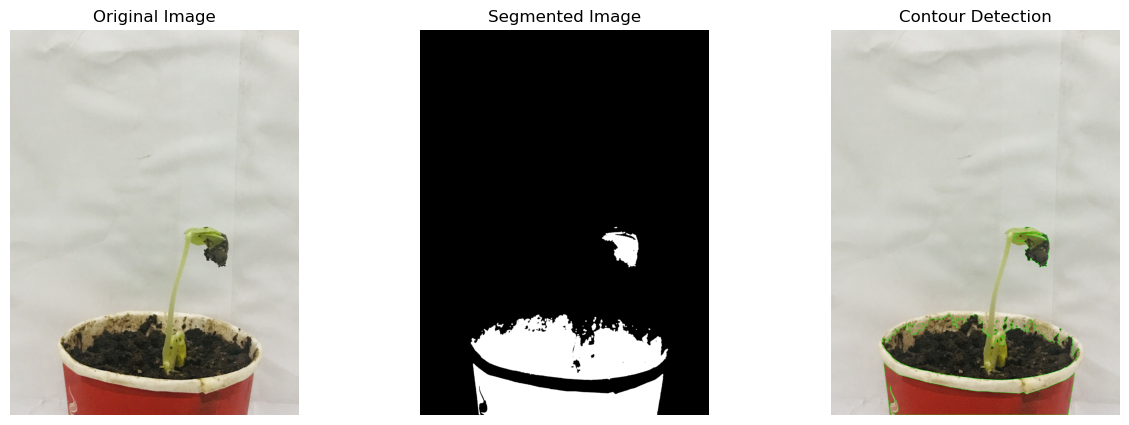

Image: Plant2_Day6_Evening_Side, Height (Pixels): 2150, Height (CM): 10.75


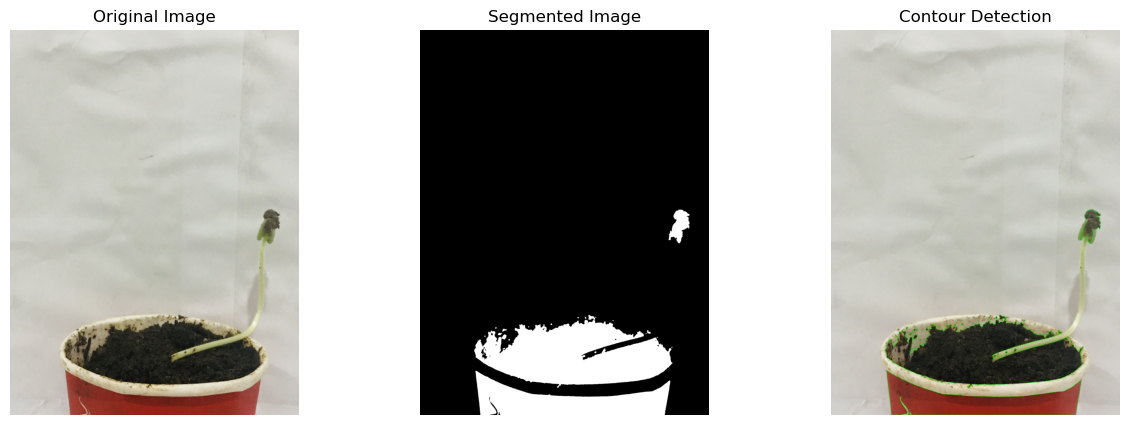

Image: Plant3_Day6_Evening_Side, Height (Pixels): 1148, Height (CM): 5.74


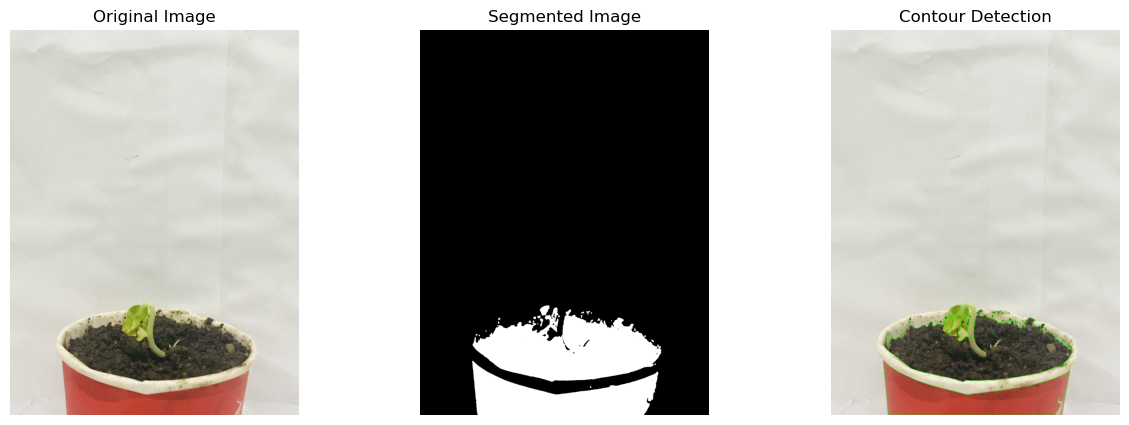


Report saved as 'Plant_Images/Day6_Evening\Segmentation_Report_Day06Evening.xlsx'


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define paths
image_folder = "Plant_Images/Day7_Evening"
output_folder = "Output_Images/Day7_Evening"

# Create output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Correct pixel-to-cm conversion factor
PIXEL_TO_CM = 0.005  # Adjusted to ensure correct height

# List all image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

def segment_and_analyze(image_path, save_path, image_name):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's Thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate plant area (in pixels)
    plant_area = sum(cv2.contourArea(cnt) for cnt in contours)

    # Calculate plant height (bounding box height)
    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))  
        plant_height_px = h  # Height in pixels
        plant_height_cm = plant_height_px * PIXEL_TO_CM  # Convert to cm
    else:
        plant_height_px = 0  
        plant_height_cm = 0
    
    # Debugging output
    print(f"Image: {image_name}, Height (Pixels): {plant_height_px}, Height (CM): {plant_height_cm:.2f}")

    # Draw contours on the original image
    contour_image = image_rgb.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    
    # Save the output images
    cv2.imwrite(os.path.join(save_path, f"{image_name}_original.jpg"), cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(save_path, f"{image_name}_segmented.jpg"), cleaned)
    cv2.imwrite(os.path.join(save_path, f"{image_name}_contour.jpg"), cv2.cvtColor(contour_image, cv2.COLOR_RGB2BGR))

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(cleaned, cmap="gray")
    axes[1].set_title("Segmented Image")
    axes[1].axis("off")
    
    axes[2].imshow(contour_image)
    axes[2].set_title("Contour Detection")
    axes[2].axis("off")
    
    plt.show()
    
    return plant_area, plant_height_px, plant_height_cm

# Analyze all images
segmentation_results = []

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image_name, _ = os.path.splitext(image_file)  
    plant_area, plant_height_px, plant_height_cm = segment_and_analyze(image_path, output_folder, image_name)
    
    segmentation_results.append({
        "Image": image_file,
        "Plant Area (px)": plant_area,
        "Plant Height (px)": plant_height_px,
        "Plant Height (cm)": round(plant_height_cm, 2)
    })

# Save the report inside "Plant_Images/Day11_Evening"
excel_output_path = os.path.join(image_folder, "Segmentation_Report_Day07Evening.xlsx")

df_results = pd.DataFrame(segmentation_results)
df_results.to_excel(excel_output_path, index=False, engine="openpyxl")

print(f"\nReport saved as '{excel_output_path}'")
